In [1]:
from autoencoder import *

First, we load the dataset and pick out the first four columns. We are trying to build the surface using only $p,T,\rho,h$, but the database includes saturations and a phase index that would be kind of cheating. We can use the phase index later as a way of comparing the classifier stage.

In [2]:
dataset = tf.data.experimental.make_csv_dataset(
    'sharded/*.csv',
    1000,
    select_columns=['T',' p',' rho',' h']
)

The autoencoder object does most of the work. It plops multiple graphs for training and evaluating the encode and decode phases into the graph context. The PolyAutoencoder is just one layer in and one layer out of polynomials. Note that we are only using a linear encoding phase, on the Ansatz that we can learn a set of primary variables that are a linear combination of intensive variables---we know that $p,T$ are good most of the time. On the decode end, we know that the surfaces are curved so we need higher order polynomials. We'll add a classification layer later.

In [4]:
graph = tf.Graph()
with graph.as_default():
    stream = atu.make_datastream(
        dataset,batch_size=0,buffer_size=1000)
    tr_x = tf.transpose(stream)
#     au = PolyAutoencoder(4,2,tr_x, 1,2)
    au = ClassifyingPolyAutoencoder(4,2,tr_x, 1,2, 6,12)
    init=tf.global_variables_initializer()

We set up a session,

In [5]:
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)
init.run(session=sess)

run the trainer a bunch,

In [6]:
nepoch = 100
for i in xrange(nepoch):
    #train_step.run(session=sess)
    sess.run(au.train_step)
    if i%(nepoch/10)==(nepoch/10)-1:
        print au.goal.eval(session=sess)

473.15198
344.08942
167.9118
130.55246
105.43528
55.291924
50.82686
42.07094
25.71075
16.565289


And then evaluate the encoder and write another csv.

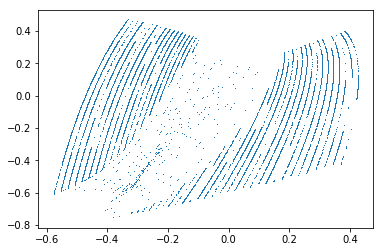

In [7]:
header="T, p, rho, h"
au.save_fit("surf_uv.csv",header)

We can now inspect the linear encoder and determine what are the primary variables we picked:

In [9]:
au.vars['enc_W'].eval()

array([[ 0.53353447, -0.24665879],
       [ 0.54107803,  0.61397874],
       [-0.23402123,  0.48514822],
       [ 0.43947974, -0.27315745]], dtype=float32)

Now we also want to save it.

In [10]:
tf.saved_model.simple_save(sess,"test",
                          inputs={"q":au.i_q},
                          outputs={"x":au.o_x})

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: test/saved_model.pb


What are the different things I want to try?

There are different model architectures I want to try:

1. Explicitly set $\rho$ and $h$ to be the primary variables by not training the encoder.
2. Initialize the encoder randomly vs. with the above initialization of $W=[[0,0,1,0],[0,0,0,1]]$
3. Have just a polynomial decoder of different orders.
4. Try different classifying decoders.
5. See if the classifiers can predict the phase if we inspect without explicitly training with phase information.

## Now lets try to solve it

In [67]:
i_q0 = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
i_qi = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
p_inf = tf.constant(-0.55)
T_inf = tf.constant(-0.51)
Dt = tf.constant(0.01)

In [111]:
def m_and_r(q):
    x = au.decode(q)
    T,p,rho,h=tf.split(x,4,axis=-1)
    m = tf.concat([rho,h],axis=-1)
#     rate = tf.concat([1.0*(p_inf-p), 0.0*(T_inf-T)],axis=-1)
    rate = tf.concat([0*p+1.0, 0*T],axis=-1)
    return m,rate

In [112]:
m_i,r_i = m_and_r(i_qi)
m_0,r_0 = m_and_r(i_q0)
lhs = m_i - Dt*r_i
rhs = m_0
K = atu.vector_gradient(lhs,i_qi)

In [113]:
q_i = np.array([[0.0,0.0]])
q_0 = np.array([[0.0,0.0]])
rhs_0 = sess.run(rhs,feed_dict={i_qi:q_i,i_q0:q_0})
ev = lambda x : sess.run(x, feed_dict={i_qi:q_i,i_q0:q_0})
print ev([o_xi])[0]
print ev([r_i ])[0]
for k in range(10):
    K_k,lhs_k = ev([K,lhs])
    R = rhs_0-lhs_k
    
    Dq = np.linalg.solve(K_k[0,:,:].T,R[0,:])
    q_i[:] = q_i + 1.0*Dq
#     print lhs_k
    print np.linalg.norm(Dq)," ",ev([o_xi])[0]
#     print ev([o_xi])[0]

[[-0.12115256  0.05136268  0.03143227 -0.0359691 ]]
[[ 1. -0.]]
0.16097233   [[-0.09252375  0.24203807  0.03737324 -0.03459398]]
0.0793316   [[-0.08465182  0.3369699   0.04045301 -0.03563117]]
0.036144022   [[-0.08207543  0.380468    0.04122904 -0.03589897]]
0.012823837   [[-0.08131155  0.3959384   0.04140668 -0.03596027]]
0.0021569247   [[-0.08119078  0.39854234  0.04143154 -0.03596883]]
6.256339e-05   [[-0.08118733  0.39861792  0.04143228 -0.03596909]]
2.301814e-06   [[-0.08118747  0.39861512  0.04143226 -0.03596911]]
2.4719877e-06   [[-0.08118731  0.3986181   0.04143226 -0.03596909]]
8.522427e-08   [[-0.08118734  0.39861798  0.04143227 -0.03596911]]
1.3638686e-06   [[-0.08118723  0.39861965  0.04143226 -0.03596909]]
8.522689e-08   [[-0.08118725  0.39861953  0.04143228 -0.0359691 ]]
1.0232172e-06   [[-0.08118731  0.39861828  0.04143226 -0.0359691 ]]
1.1935346e-06   [[-0.08118724  0.39861977  0.04143225 -0.03596909]]
1.0232185e-06   [[-0.08118717  0.39862096  0.04143227 -0.03596909]]
